In [45]:
## IMPORT RELEVANT DICTIONARIES AND MODULES
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.stats import norm 
import scipy.stats as sts
from scipy.stats import t

In [46]:
## PARAMS FOR REDUCED RATE MODEL
V_rest = -70.0 # mV, resting membrane potential

tau_E = 20.0 # ms, E neuron time constant 
tau_I = 10.0 # ms, I neuron time constant
tau = [tau_E, tau_I]

W_EE = 1.25 # mV*s, connection weight 
W_IE = 1.2 # mV*s, connection weight
W_EI = 0.65 # mV*s, connection weight
W_II = 0.5 # mV*s, connection weight
W = np.array([[W_EE, -W_EI],
            [W_IE, -W_II]])

b = 2.0 # mV, input baseline

sigma_0E = 0.2 # mV, noise standard deviation 
sigma_0I = 0.1 # mV, noise standard deviation sigma_noise = np.zeros((2,2))
sigma_noise[0,0] = (np.power(sigma_0E,2))*(1+tau_E/tau_noise)
sigma_noise[1,1] = (np.power(sigma_0I,2))*(1+tau_I/tau_noise)

tau_noise = 50.0 # ms, noise correlation time constant 

k = 0.3 # mV^-n*s^-1, nonlinearity gain 
n = 2 # nonlinearity exponent 

dt = 0.1 # time step

In [47]:
def generate_noise(n_step, 
                   N_E=1,
                   N_I=1,
                   scale=0.1,
                   tau_noise = tau_noise,
                   sigma_noise = sigma_noise):
    """
    Generate input noise for N units, each unit for n_steps
    """
    N = N_E+N_I
    # record 
    noise_list = np.empty((N, n_step))
    
    # initialize 
    noise = np.zeros((N,))
    
    r = norm.rvs(size=(N, n_step), scale = scale)
    
    # pregenerate Weiner process 
    #Weiner = generate_Weiner_process(N, n_step, dt, scale=scale)
    
    sigma_noise_multi = np.concatenate((sigma_noise[0,0]*np.ones((N_E,1)), sigma_noise[1,1]*np.ones((N_I,1))), axis=None)
    sigma_noise = np.diag(sigma_noise_multi)
    
    for i_step in range(n_step):
        
        # update noise 
        # checked Nov 20th 
        d_noise = (-noise*dt + (np.sqrt(2*tau_noise*sigma_noise)).dot(r[:,i_step]))/tau_noise
        noise = noise + d_noise
        noise_list[:,i_step] = noise
        
    return noise_list

In [149]:
def simulate(N_E=1,
             N_I=1,
             V_rest = V_rest, 
             n_step = 10000, # default simulate for 1s
             start_step = 0,
             dt = 0.1, 
             h = b, 
             W = W, 
             k = k, 
             n = n,
             tau = tau,
             noise_scale=1.0,
             h_scale=0,
             V_init = None):
    """
    V_rest: resting potential 
    N: total number of neurons 
    n_step: total simulation steps 
    dt: simulation time step 
    h: constant input 
    W: exc and inh weights
    k,n: parameter for r supralinear function
    tau: list of tau for corresponding units 
    """
    
    # Initialization
    N = N_E+N_I
    tau = np.concatenate((tau_E*np.ones((N_E,1)), tau_I*np.ones((N_I,1))), axis=None)
    
    if V_init is None: 
        V = V_rest * np.ones((N,)) # start at resting potential 
    else: 
        V = V_init
    V_rest_vec = V_rest*np.ones((N,))
    # pre-calculate input strenght noise
    h = np.random.normal(h,h_scale,n_step)
    #H = h*np.ones((N,))
    noise = np.zeros((N,))
    
    # record 
    record_step = n_step - start_step
    V_list = np.empty((N, record_step))
    noise_record_list = np.empty((N, record_step))
    r_list = np.empty((N, record_step))
    H_list = np.empty((N, record_step))
    
    # pre-generate noise 
    noise_list = generate_noise(n_step,N_E, N_I, scale=noise_scale)
    
    
    for i_step in range(n_step):
        # change input strength
        H = h[i_step]*np.ones((N,))
        # get noise 
        noise = noise_list[:,i_step]
        
        # get R 
        # checked Nov 20th 
        # R = 10*k*np.maximum(0.0,(V-V_rest))                       #linear
        # R = k*np.power(np.maximum(0.0, V-V_rest), n) #supralinear
        R = 70*(1/(1+np.exp(-V+V_rest+10)))                        #sublinear/sigmoid


        
        # update membrane potential 
        dv = np.divide(dt*(-V + V_rest_vec + H + noise + W.dot(R)), tau)
        # dv = np.divide(dt*(-V + V_rest_vec + H + noise), tau) # verified for the case of feedforward, Nov 21st
        # dv = np.divide(dt*(-V + V_rest_vec + H + W.dot(R)), tau) # verified for the case of no noise, Nov 21st 
        V = V + dv 
        
        # record 
        if i_step >= start_step: 
            r_list[:,i_step-start_step] = R
            V_list[:,i_step-start_step] = V
            noise_record_list[:,i_step-start_step] = noise
            H_list[:,i_step-start_step] = H
        
    V_last = V
        
    return V_list, r_list, noise_record_list, H_list, V_last

In [150]:
### RUN MODEL TO CALC KLDIVERGENCE ###
# initialize variables
N_E = 1        #number excitatory
N_I = 1        #number inhibitory
h = 2           #starting input strength
noise_scale = 1  #std of cells
h_scale = 0      #std of h
n_step = 10000   #number of timesteps; 10000=1sec

W_multi=W
#W_multi=get_connectivity(N_E,N_I)

trials = 10
num_h = [2,4,6]
num_sigmah = [0, 1]
V = np.empty([trials,len(num_h),len(num_sigmah), n_step-2000])
R = np.empty([trials,len(num_h),len(num_sigmah), n_step-2000])
for trial in range(trials):
    for h in num_h:
        for h_scale in num_sigmah:
            [V_list, r_list, noise_list, H_list, V_last] = simulate(N_E=N_E, N_I=N_I, n_step=n_step, h=h, W=W_multi,
                                                                noise_scale=noise_scale, h_scale=h_scale,start_step=2000)

            exc = V_list[:N_E] # np.shape(exc) = 1 x 8000
            inh = V_list[N_E:]
            
            excR = r_list[:N_E] # np.shape(exc) = 1 x 8000
            inhR = r_list[N_E:]
        
            V[trial, num_h.index(h), num_sigmah.index(h_scale), :] = exc;
            R[trial, num_h.index(h), num_sigmah.index(h_scale), :] = excR;

In [151]:
## PULL/ASSIGN RELEVANT OUTPUT ARRAYS FOR KL

pdf_mat_2_0 = R[:, 0, 0, :] # H=2, std input noise =0
pdf_mat_2_1 = R[:, 0, 1, :]
pdf_mat_4_0 = R[:, 1, 0, :]
pdf_mat_4_1 = R[:, 1, 1, :] # H=4, std input noise =1
pdf_mat_6_0 = R[:, 2, 0, :]
pdf_mat_6_1 = R[:, 2, 1, :] 

In [152]:
### FOR CALCULATING KL DIVERGENCE
## STILL NEED TO MAKE BINS COMMON ACROSS ALL

# CONCATE ALL TRIALS INTO SINGLE ARRAY
free_2=np.ndarray.flatten(pdf_mat_2_0);
free_4=np.ndarray.flatten(pdf_mat_4_0);
free_6=np.ndarray.flatten(pdf_mat_6_0);

noise_2=np.ndarray.flatten(pdf_mat_2_1);
noise_4=np.ndarray.flatten(pdf_mat_4_1);
noise_6=np.ndarray.flatten(pdf_mat_6_1);

# DISCRETIZE POSSIBLE vM VALUES INTO SINGLE COMMON RANGE
# To compare h=2 to h=4
min1 = np.min(np.minimum(free_2, noise_2))
max1 = np.max(np.maximum(free_4, noise_4))
bins1 = np.linspace(min1, max1, 100)

# To compare h=4 to h=6
min2 = np.min(np.minimum(free_4, noise_4))
max2 = np.max(np.maximum(free_6, noise_6))
bins2 = np.linspace(min2, max2, 100)


# GET PMFs WITH COMMON RANGE
# Free from noise
y = np.histogram(free_2, bins = bins1, density = True)
y1 = np.histogram(free_4, bins = bins1, density = True)
z = np.histogram(free_4, bins = bins2, density = True)
z1= np.histogram(free_6, bins = bins2, density = True)

# With 1 std white noise for stimulus input
yn= np.histogram(noise_2, bins = bins1, density = True)
yn1= np.histogram(noise_4, bins = bins1, density = True)
zn = np.histogram(noise_4, bins = bins2, density = True)
zn1= np.histogram(noise_6, bins = bins2, density = True)

# GRAB PDF ARRAY FROM HIST TUPLE
y_=y[0];
y1_=y1[0];
z_=z[0];
z1_=z1[0];
yn_=yn[0];
yn1_=yn1[0];
zn_=zn[0];
zn1_=zn1[0];

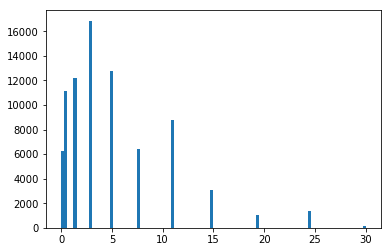

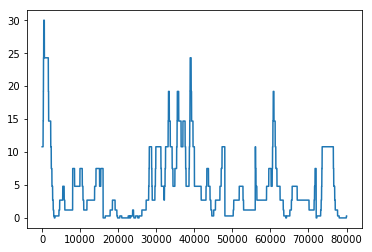

In [165]:
## VISUALIZE THE R DISTRUBTION ACROSSS ALL TIMESTEPS FOR AN EXCITATORY CELL

x = y_; # DESIGNATE CELL

# Plot pmf of timesteps R values
plt.figure(0)
plt.hist(xn,100);

# Plot R(t) for all trials in a single concatenated array
plt.figure(1)
plt.plot(xn)


In [145]:
# Replace all zero values in array
def replacezero (x):
    min_a = np.min([i for i in x if (i!=0.0)&(i!=np.nan)])
    for i_ind, i_x in enumerate(x):
        if i_x == 0.0:
            x[i_ind] = min_a/2
            
    return x

In [153]:
# PULL ZEROS FROM PMFs
y_ = replacezero(y_)
y1_ = replacezero(y1_)
z_ = replacezero(z_)
z1_ = replacezero(z1_)
yn_ = replacezero(yn_)
yn1_ = replacezero(yn1_)
z_ = replacezero(zn_)
zn1_ = replacezero(zn1_)

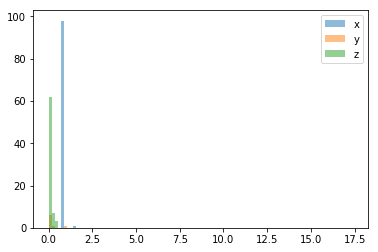

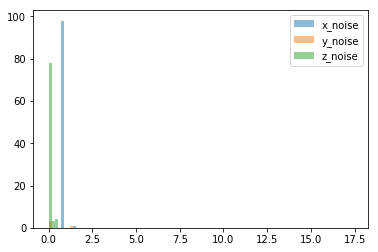

In [160]:
## FIGURES TO VISUALIZE DISTS W AND W/O NOISE

bins = np.linspace(min1, max2, 100)

plt.hist(y_, bins, alpha=0.5, label='x')
plt.hist(y1_, bins, alpha=0.5, label='y')
plt.hist(z1_, bins, alpha=0.5, label='z')
plt.legend(loc='upper right')
plt.show()

plt.hist(yn_, bins, alpha=0.5, label='x_noise')
plt.hist(yn1_, bins, alpha=0.5, label='y_noise')
plt.hist(zn1_, bins, alpha=0.5, label='z_noise')
plt.legend(loc='upper right')
plt.show()

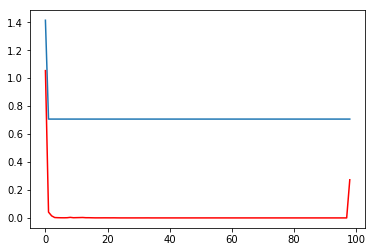

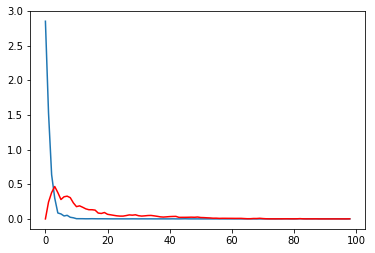

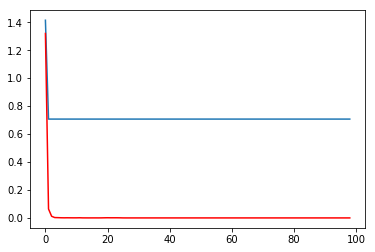

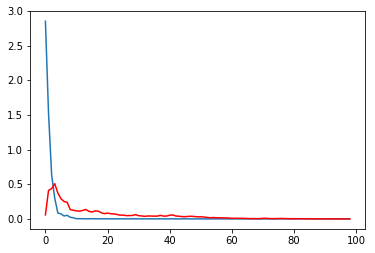

In [154]:
 # VISUALIZE BINNED DISTS
plt.figure(0)
plt.plot(y_)
plt.plot(y1_, 'r')
plt.figure(1)
plt.plot(z_)
plt.plot(z1_, 'r')
plt.figure(2)
plt.plot(yn_)
plt.plot(yn1_, 'r')
plt.figure(3)
plt.plot(zn_)
plt.plot(zn1_, 'r')

In [137]:
## FUNCTION TO CALC KL
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)#

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [148]:
## CALC KL DIVERGENCE FOR SUPRALINEAR I/O SSN ITERATION
klsup_f24 = KL(y_, y1_) # This calculates the KL divergence between the distribution of rate values across all timesteps of all trials
    # Above for h=2 and h=2 comparision with zero noise
klsup_f46 = KL(z_, z1_)
    # Above for h=4 and h=6 comparision with zero noise
klsup_n24 = KL(yn_, yn1_)
    # Above for h=4 and h=6 comparision with 1 STD white noise for h input
klsup_n46 = KL(zn_, zn1_)
    # Above for h=4 and h=6 comparision with 1 STD white noise for h input

print(klsup_f24)
print(klsup_f46)
print(klsup_n24)
print(klsup_n46)

2.73609447187
2.39251186442
2.65264883868
0.682635536569


In [139]:
## CALC KL DIVERGENCE FOR SATURATING I/O SSN INTERATION
klsub_f24 = KL(y_, y1_)
    # Above for h=2 and h=2 comparision with zero noise
klsub_f46 = KL(z_, z1_)
    # Above for h=4 and h=6 comparision with zero noise
klsub_n24 = KL(yn_, yn1_)
    # Above for h=2 and h=4 comparision with 1 STD white noise for h input
klsub_n46 = KL(zn_, zn1_)
    # Above for h=4 and h=6 comparision with 1 STD white noise for h input

print(klsub_f24)
print(klsub_f46)
print(klsub_n24)
print(klsub_n46)

0.370568264338
0.427950144193
1.01462317097
0.516231138149


In [155]:
## CALC KL DIVERGENCE FOR LINEAR I/O SSN INTERATION
kllin_f24 = KL(y_, y1_)
     # Above for h=2 and h=2 comparision with zero noise
kllin_f26 = KL(z_, z1)
     # Above for h=4 and h=6 comparision with zero noise
kllin_n24 = KL(yn_, yn1_)
    # Above for h=2 and h=4 comparision with 1 STD white noise for h input
kllin_n26 = KL(zn_, zn1_)
    # Above for h=4 and h=6 comparision with 1 STD white noise for h input

print(kllin_f24)
print(kllin_f46)
print(kllin_n24)
print(kllin_n46)

ValueError: setting an array element with a sequence.